# Evaluate Machine teaching approach
Training is done efter creating a teaching sets by reading the personas and their scenarios.

In [17]:
#Setup
from fastai import *          # Quick accesss to most common functionality
from fastai.tabular import *  # Quick accesss to tabular functionality     # Access to example data provided with fastai
from fastai.vision import *
sys.path.append("../code") # go to parent dir
from commuter import *
print("Python version: "+sys.version)
PATH="../data/"
dep_var = 'journey'
cat_names = ["detectedActivity","weekday"]
cont_names =["geoHash","minuteOfDay"]
usecols=['detectedActivity','geoHash','minuteOfDay','weekday','journey']
procs = [FillMissing, Categorify, Normalize]
# Uncomment active user
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
personas = pd.read_csv("../data/personas.csv")
personaname = personas.loc[personas['id']==user]['name'].iloc[0]
#stations = pd.read_csv("../data/stations.csv")
    
def select_rows(predicted_journey,correct_journey,result_set):
    result = []
    for row in result_set.itertuples():
        if (row[1]==predicted_journey and row[4]==correct_journey):
            result.append(row)
    return result

Python version: 3.7.2 (default, Dec 29 2018, 06:19:36) 
[GCC 7.3.0]


### Train learner.

epoch,train_loss,valid_loss,accuracy
1,1.430321,1.743284,0.125000
2,0.976784,1.209987,0.750000
3,0.663649,0.530100,0.966667
4,0.475567,0.172871,1.000000
5,0.337906,0.075601,1.000000
6,0.249240,0.051311,1.000000
7,0.196958,0.043796,1.000000


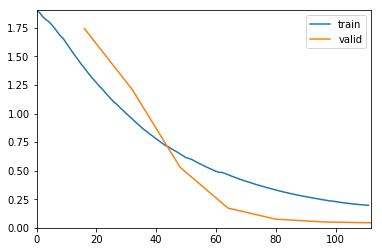

CPU times: user 5.27 s, sys: 4.5 s, total: 9.77 s
Wall time: 11.1 s


In [18]:
#%%capture
#teachingSetName="_teaching_set_minimal.csv"
#teachingSetName="_teaching_set.csv"
teachingSetName="_teaching_set_aug.csv"
#teachingSetName="_train_valid.csv"
teachingSet = pd.read_csv(PATH+user+teachingSetName,usecols=usecols)
teachingSet= make_shure_we_got_enough_rows(teachingSet)
valid_idx = list(np.random.randint(0,len(teachingSet),int(len(teachingSet)*0.1)))
data = (TabularList.from_df(teachingSet, path=user, cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var)
                .databunch())
learner=tabular_learner(data, layers=[200,100], metrics=accuracy,callback_fns=ShowGraph)
%time learner.fit_one_cycle(7)


In [15]:
testset = pd.read_csv(PATH+user+"_test.csv",usecols=['detectedActivity','geoHash','minuteOfDay','weekday','journey'])
#testset = pd.read_csv(PATH+user+"_start14days.csv")
result = evaluate_learning(learner,testset)
a = np.asarray(result)
#print(a)
np.savetxt("saved/"+user+"_result"+teachingSetName,a,delimiter=',',fmt=["%s","%10.2f","%10.2f","%s"])

### Check towards users test set 
Gives som kind of baseline for the trained model by evaluation on the users [test set](../data/data.md)

In [9]:
testSet = pd.read_csv(PATH+user+"_test.csv",usecols=['detectedActivity','geoHash','minuteOfDay','weekday','journey'])
result = predict_journeys(learner,testSet)
print("Test set accuracy for: "+personaname+":"+str(result))

Test set accuracy for: Maria:1.0


### Show accuracy over the 14 first days
Prints results from training for different teaching sets. Standard deviation for the accuracy is plotted in the graph. The "No teaching" bar represent traininn over one year of [clean data](../data/data.md).
<br>Teachingsets used:<br>
Andrea:
[Verbose](../data/ehaBtfOPDNZjzy1MEvjQmGo4Zv12_teaching_set.csv)
[Limited](../data/ehaBtfOPDNZjzy1MEvjQmGo4Zv12_teaching_set_minimal.csv)
<br>Björn:
[Verbose](../data/hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2_teaching_set.csv)
[Limited](../data/hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2_teaching_set_minimal.csv)
<br>Maria:
[Verbose](../data/tnK534JMwwfhvUEycn69HPbhqkt2_teaching_set.csv)
[Limited](../data/tnK534JMwwfhvUEycn69HPbhqkt2_teaching_set_minimal.csv)

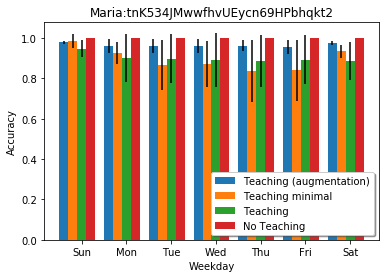

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
teaching_ax00= pd.read_csv("saved/"+user+"_result_teaching_set_aug.csv",header=None,names=["Journey_pred", "Accuracy", "Day","Journey_corr"])
teaching_ax00_std = teaching_ax00.groupby(by="Day")["Accuracy"].std().reset_index().rename(index=str,columns=({"Accuracy":"std"}))
teaching_ax00 = teaching_ax00.groupby(by="Day")["Accuracy"].mean().reset_index()

teaching_ax0= pd.read_csv("saved/"+user+"_result_teaching_set_minimal.csv",header=None,names=["Journey_pred", "Accuracy", "Day","Journey_corr"])
teaching_ax0_std = teaching_ax0.groupby(by="Day")["Accuracy"].std().reset_index().rename(index=str,columns=({"Accuracy":"std"}))
teaching_ax0 = teaching_ax0.groupby(by="Day")["Accuracy"].mean().reset_index()

teaching_ax1= pd.read_csv("saved/"+user+"_result_teaching_set.csv",header=None,names=["Journey", "Accuracy", "Day","Journey_corr"])
teaching_ax1_std = teaching_ax1.groupby(by="Day")["Accuracy"].std().reset_index().rename(index=str,columns=({"Accuracy":"std"}))
teaching_ax1 = teaching_ax1.groupby(by="Day")["Accuracy"].mean().reset_index()

teaching_ax2= pd.read_csv("saved/"+user+"_result_train_valid.csv",header=None,names=["Journey", "Accuracy", "Day","Journey_corr"])
teaching_ax2_std = teaching_ax2.groupby(by="Day")["Accuracy"].std().reset_index().rename(index=str,columns=({"Accuracy":"std"}))
teaching_ax2 = teaching_ax2.groupby(by="Day")["Accuracy"].mean().reset_index()
bar_width = 0.20
fig,ax0  = plt.subplots()
ax0.set_title(personaname+":"+user)
ax0.bar(teaching_ax00["Day"]-2*bar_width,teaching_ax00["Accuracy"],bar_width,label='Teaching (augmentation)',yerr=teaching_ax00_std["std"])
ax0.bar(teaching_ax0["Day"]-bar_width,teaching_ax0["Accuracy"],bar_width,label='Teaching minimal',yerr=teaching_ax0_std["std"])
ax0.bar(teaching_ax1["Day"],teaching_ax1["Accuracy"],bar_width, label='Teaching',yerr=teaching_ax1_std["std"])
ax0.bar(teaching_ax2["Day"]+bar_width,teaching_ax2["Accuracy"],bar_width, label='No Teaching',yerr=teaching_ax2_std["std"])
plt.xticks(np.arange(7), ("Sun","Mon","Tue","Wed","Thu","Fri","Sat"))
plt.xlabel('Weekday')
plt.ylabel('Accuracy')
legend = ax0.legend(loc='lower right', shadow=True, fontsize='medium')
plt.show()

### Confusion Matrix
Confusion matrix over the first 14 days

Maria


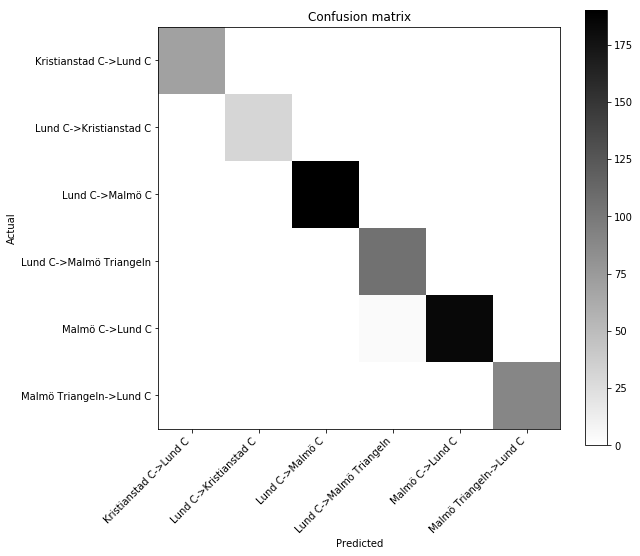

In [7]:
from pandas_ml import ConfusionMatrix
#teachingSetName="_teaching_set_minimal.csv"
#teachingSetName="_teaching_set.csv"
teachingSetName="_teaching_set_aug.csv"
#teachingSetName="_train_valid.csv"
result_teaching= pd.read_csv("saved/"+user+"_result"+teachingSetName,header=None,names=["Journey_pred", "Accuracy", "Day","Journey_corr"])
y_true = result_teaching["Journey_corr"].apply(from_to)
y_pred = result_teaching["Journey_pred"].apply(from_to)
confusion_matrix = ConfusionMatrix(y_true,y_pred)
print(personaname)
#print("Confusion matrix:\n%s" % confusion_matrix)
confusion_matrix.plot()

In [17]:
#Predicted,Actual
#Print rows in test set that corresponds to predicted result:actual result
testset = pd.read_csv(PATH+user+"_start14days.csv")
result = select_rows(8170381079,8115681079,result_teaching)
for i in range(len(result)):
    #print(result[i].Index)
    print(testset.iloc[result[i].Index])

In [7]:
#confusion_matrix.print_stats()

#### Predict on scenarios

In [5]:
scenario_1_df = pd.read_csv(PATH+user+"_scenario_1.csv")
scenario_1_predicted = learner.predict(scenario_1_df.iloc[0])
scenario_2_df = pd.read_csv(PATH+user+"_scenario_2.csv")
scenario_2_predicted = learner.predict(scenario_2_df.iloc[0])
scenario_3_df = pd.read_csv(PATH+user+"_scenario_3.csv")
scenario_3_predicted = learner.predict(scenario_3_df.iloc[0])
print("Scenario 1 for "+personaname+" (predicted:correct) "+str(scenario_1_predicted[0])+":"+str(scenario_1_df.iloc[0].journey))
print("Scenario 2 for "+personaname+" (predicted:correct) "+str(scenario_2_predicted[0])+":"+str(scenario_2_df.iloc[0].journey))
print("Scenario 3 for "+personaname+" (predicted:correct) "+str(scenario_3_predicted[0])+":"+str(scenario_3_df.iloc[0].journey))

Scenario 1 for Andrea (predicted:correct) 8107981156:8107981156
Scenario 2 for Andrea (predicted:correct) 8107981703:8107981703
Scenario 3 for Andrea (predicted:correct) 8115681079:8115681079
